In [1]:
import tailor
import pandas as pd
import matplotlib.pyplot as plt

# Create initial DataFrame

In [2]:
raw_df = tailor.load_raw_dataframe()
df_revenue = raw_df[['article_id', 'time_on_sale', 'revenue']]

### To give an example, the dataframe looks like this ...

In [3]:
df_revenue.head()

,article_id,time_on_sale,revenue
0,900001,0,107.90
1,900001,1,119.90
2,900001,2,179.85
3,900001,4,297.75
4,900001,5,359.70


# Create a Benchmark Series

### Now reshape the dataframes into a format which makes it easier to calculate the mean of each time_on_sale value.  The following steps must be done for each  performance measure.  For now, we will just do it for the dataframe with the column 'revenue' (df_revenue)



In [4]:
df_pivoted = pd.pivot_table(df_revenue, values='revenue', index='article_id', columns='time_on_sale')
df_reshaped = pd.DataFrame(df_pivoted.to_records()) #cast pivot table into DataFrame 
df_reshaped.head()

,article_id,0,1,2,3,4,5,6,7,8,...,172,173,174,175,176,177,178,179,180,181
0,900001,107.90,119.90,179.85,NaN,297.75,359.70,239.80,234.36,419.65,...,159.80,64.72,107.85,64.70,75.90,107.85,39.95,NaN,155.80,83.90
1,900002,39.95,69.90,109.86,149.80,NaN,155.80,394.50,421.30,319.60,...,NaN,79.90,119.85,199.75,221.67,335.02,454.67,NaN,341.18,208.44
2,900003,29.95,79.86,317.57,NaN,169.68,119.80,269.55,119.80,344.52,...,NaN,106.89,15.96,73.40,30.32,149.50,NaN,53.85,21.54,53.85
3,900004,15.96,NaN,NaN,19.95,135.45,178.20,NaN,191.50,135.24,...,15.96,15.96,NaN,17.95,39.90,NaN,36.90,37.40,NaN,NaN
4,900005,57.84,99.75,119.70,NaN,79.80,176.58,99.60,114.72,56.37,...,39.90,79.80,59.85,NaN,79.80,18.45,NaN,78.80,59.85,19.95


### Next, calculate the mean of each column. Therefore, you have the mean for each time_on_sale value. This series can be used as a benchmark series. 

In [5]:
revenue_benchmark = df_reshaped.mean(axis=0)
revenue_benchmark.head()


article_id    904354.500000
0                 94.465988
1                168.770303
2                195.982764
3                204.494422
dtype: float64

### Drop mean of article ids. It makes no sense and we dont need it 

In [6]:
revenue_benchmark = revenue_benchmark.drop(revenue_benchmark.index[0])
revenue_benchmark.head()

0     94.465988
1    168.770303
2    195.982764
3    204.494422
4    213.679115
dtype: float64

### Cast series into a DataFrame

In [7]:
df_revenue_benchmark = pd.DataFrame()
df_revenue_benchmark['time_on_sale'] = revenue_benchmark.keys()
df_revenue_benchmark['mean_revenue'] = revenue_benchmark.values
df_revenue_benchmark.head()

,time_on_sale,mean_revenue
0,0,94.465988
1,1,168.770303
2,2,195.982764
3,3,204.494422
4,4,213.679115


# Calculate distance to Benchmark Series

### Merging both DataFrames yields in ...

In [8]:
result = pd.merge(df_revenue, df_revenue_benchmark, how='left', on='time_on_sale', left_index=False, right_index=True, sort=True, validate='m:1')
result = result.reset_index()
result = result.drop('index', axis=1)
result = result.rename(index=str, columns={'mean_revenue_y':'mean_revenue'})
result.head()


,article_id,time_on_sale,revenue,mean_revenue
0,900001,0,107.90,94.465988
1,900002,0,39.95,94.465988
2,900003,0,29.95,94.465988
3,900004,0,15.96,94.465988
4,900005,0,57.84,94.465988


### Calculate the distance between revenue and mean_revenue

In [9]:
result['distance'] = ((result['revenue'] - result['mean_revenue'])**2)**0.5
result.head()

,article_id,time_on_sale,revenue,mean_revenue,distance
0,900001,0,107.90,94.465988,13.434012
1,900002,0,39.95,94.465988,54.515988
2,900003,0,29.95,94.465988,64.515988
3,900004,0,15.96,94.465988,78.505988
4,900005,0,57.84,94.465988,36.625988


### Sum up all distances to get just one value for similiarity measurement

In [10]:
result = result.groupby('article_id').sum()
result = result.reset_index()
result = result = result.drop(['revenue', 'mean_revenue'], axis=1)
result.head()

,article_id,distance
0,900001,22616.320832
1,900002,22812.484463
2,900003,36974.344787
3,900004,24830.757302
4,900005,24977.828270


In [11]:
result = result.sort_values('distance', ascending=False)
result.head()

,article_id,distance
526,900527,231100.505848
6431,906432,212770.130924
596,900597,194807.356762
1071,901072,190124.220944
1516,901517,186386.471271


# First evaluation of the similarity measurement

### Let us plot some articles with similiar distances. To find similiar values, I just had a look at the sorted result dataframe

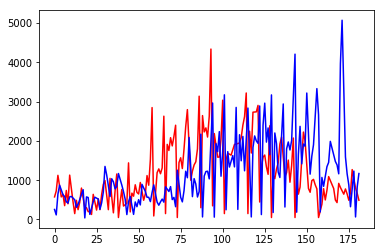

In [12]:
article_one = raw_df[raw_df['article_id']==902792]
article_two = raw_df[raw_df['article_id']==901825]

plt.plot(article_one['time_on_sale'], article_one['revenue'], 'r')
plt.plot(article_two['time_on_sale'], article_two['revenue'], 'b')


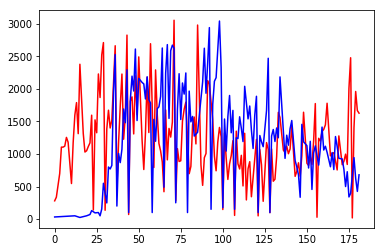

In [13]:
article_three = raw_df[raw_df['article_id']==900546]
article_four = raw_df[raw_df['article_id']==906171]

plt.plot(article_three['time_on_sale'], article_three['revenue'], 'r')
plt.plot(article_four['time_on_sale'], article_four['revenue'], 'b')

### Looks not too bad, but maybe we could split the benchmark series into multiple pieces and calculate the distances to those pieces. That could level out the effect of different shapes on similiar distances.